In [24]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

The RNN training parts of this notebook are based on the following:

https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3

In [25]:
### functions

sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(y_test, pred, labels=None):

    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [26]:
df_train = pd.read_csv('../../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)

df_test = pd.read_csv('../../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)

df_train.head()

filename                    artist                          title  \
0  country.00041.wav               Johnny Cash              Goin' By The Book   
1   reggae.00038.wav             Burning Spear              Investigation Dub   
2    disco.00070.wav  KC and The Sunshine Band     That's The Way (I Like It)   
3   reggae.00088.wav          Marcia Griffiths                Electric Boogie   
4      pop.00017.wav            Britney Spears  (I Can't Get No) Satisfaction   

     genre                                             lyrics  instrumental  \
0  country  \nYou can see it in the movies and the paper a...         False   
1   reggae  I and I old I know\nI and I old I say\nI and I...         False   
2    disco  That's the way, aha, aha\nI like it, aha, aha\...         False   
3   reggae  \nIt's electric!\n\n\nYou can't see it\nIt's e...         False   
4      pop  \nI can't get no satisfaction\nI can't get no ...         False   

                                           tokenized  \
0  ['see', 'movies', 'paper', 'tv', 'news', 'some...   
1  ['old', 'know', 'old', 'say', 'reconsider', 's...   
2  ['thats', 'way', 'aha', 'aha', 'like', 'aha', ...   
3  ['electric', 'cant', 'see', 'electric', 'got',...   
4  ['cant', 'get', 'satisfaction', 'cant', 'get',...   

                                          lemmatized  
0  [see, movie, paper, tv, news, somebody, army, ...  
1  [old, know, old, say, reconsider, see, upfully...  
2  [thats, way, aha, aha, like, aha, aha, thats, ...  
3  [electric, cant, see, electric, get, ta, feel,...  
4  [cant, get, satisfaction, cant, get, satisfact...

In [27]:
num_feats = pd.read_csv('../../data/features_30_sec.csv')
num_feats = num_feats.drop(columns=['length', 'label'])
num_feats

filename  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0    blues.00000.wav          0.350088         0.088757  0.130228  0.002827   
1    blues.00001.wav          0.340914         0.094980  0.095948  0.002373   
2    blues.00002.wav          0.363637         0.085275  0.175570  0.002746   
3    blues.00003.wav          0.404785         0.093999  0.141093  0.006346   
4    blues.00004.wav          0.308526         0.087841  0.091529  0.002303   
..               ...               ...              ...       ...       ...   
995   rock.00095.wav          0.352063         0.080487  0.079486  0.000345   
996   rock.00096.wav          0.398687         0.075086  0.076458  0.000588   
997   rock.00097.wav          0.432142         0.075268  0.081651  0.000322   
998   rock.00098.wav          0.362485         0.091506  0.083860  0.001211   
999   rock.00099.wav          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1               1530.176679          375850.073649              2039.036516   
2               1552.811865          156467.643368              1747.702312   
3               1070.106615          184355.942417              1596.412872   
4               1835.004266          343399.939274              1748.172116   
..                      ...                    ...                      ...   
995             2008.149458          282174.689224              2106.541053   
996             2006.843354          182114.709510              2068.942009   
997             2077.526598          231657.968040              1927.293153   
998             1398.699344          240318.731073              1818.450280   
999             1609.795082          422203.216152              1797.213044   

     spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0              85882.761315   3805.839606  ...     0.752740   52.420910   
1             213843.755497   3550.522098  ...     0.927998   55.356403   
2              76254.192257   3042.260232  ...     2.451690   40.598766   
3             166441.494769   2184.745799  ...     0.780874   44.427753   
4              88445.209036   3579.757627  ...    -4.520576   86.099236   
..                      ...           ...  ...          ...         ...   
995            88609.749506   4253.557033  ...     1.789867   45.050526   
996            82426.016726   4149.338328  ...     3.739020   33.851742   
997            74717.124394   4031.405321  ...     1.838090   33.597008   
998           109090.207161   3015.631004  ...    -2.812176   46.324894   
999           120115.632927   3246.908930  ...     1.794104   59.167755   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0      -1.690215   36.524071    -0.408979   41.597103    -2.303523   
1      -0.731125   60.314529     0.295073   48.120598    -0.283518   
2      -7.729093   47.639427    -1.816407   52.382141    -3.439720   
3      -3.319597   50.206673     0.636965   37.319130    -0.619121   
4      -5.454034   75.269707    -0.916874   53.613918    -4.404827   
..           ...         ...          ...         ...          ...   
995   -13.289984   41.754955     2.484145   36.778877    -6.713265   
996   -10.848309   39.395096     1.881229   32.010040    -7.461491   
997   -12.845291   36.367264     3.440978   36.001110   -12.588070   
998    -4.416050   43.583942     1.556207   34.331261    -5.041897   
999    -7.069775   73.760391     0.028346   76.504326    -2.025783   

     mfcc19_var  mfcc20_mean  mfcc20_var  
0     55.062923     1.221291   46.936035  
1     51.106190     0.531217   45.786282  
2     46.639660    -2.231258   30.573025  
3     37.259739    -3.407448   31.949339  
4     62.910812   -11.703234   55.195160  
..          ...          ...         ...  
995   54.866825    -1.193787   49.950665  
996   39.196327    -2.795338

In [28]:
train_num_feats = pd.merge(num_feats, df_train['filename'], how="inner", on="filename")
test_num_feats = pd.merge(num_feats, df_test['filename'], how="inner", on="filename")
assert len(df_train) == len(train_num_feats)
assert len(df_test) == len(test_num_feats)

In [29]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
GLOVE_MODELS = {}

for dim in ["100d", "300d"]:#["50d", "100d", "200d", "300d"]:
    glove_path = f"../../glove/glove.6B.{dim}.txt"
    glove_word2vec_path = glove_path + '.word2vec'

    if os.path.exists(glove_word2vec_path):
        # load the Stanford GloVe model
        print(f"Loading saved glove word2vec {dim} model")
        GLOVE_MODELS[dim] = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
    else:
        # load the Stanford GloVe model from txt file, convert to word2vec and save
        print(f"Creating glove word2vec {dim} model")
        glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        glove_model.save_word2vec_format(glove_word2vec_path)
        GLOVE_MODELS[dim] = glove_model

print(GLOVE_MODELS)

Loading saved glove word2vec 100d model
Loading saved glove word2vec 300d model
{'100d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f92b0915df0>, '300d': <gensim.models.keyedvectors.KeyedVectors object at 0x7f92b0915790>}


In [30]:
from sklearn.preprocessing import LabelBinarizer

# Renaming, Input -> X, Output -> y
#X_tf_train = df_train['lyrics']
#X_tf_test = df_test['lyrics']
X_tf_train = df_train['lemmatized'].apply(' '.join)
X_tf_test = df_test['lemmatized'].apply(' '.join)

# Convert labels into a one-hot vector (length = number of genres)
lab = LabelBinarizer()
lab.fit(df_train['genre'])
y_tf_train = lab.transform(df_train['genre'])
y_tf_test = lab.transform(df_test['genre'])

# Example (you can modify n)
print('Coding of labels into a one-hot vector, e.g.: ')
print(df_train['genre'][0], '->', y_tf_train[0])
print(df_train['genre'][1], ' ->', y_tf_train[1])
print(df_train['genre'][2], '  ->', y_tf_train[2])

Coding of labels into a one-hot vector, e.g.: 
country -> [0 1 0 0 0 0 0 0]
reggae  -> [0 0 0 0 0 0 1 0]
disco   -> [0 0 1 0 0 0 0 0]


In [31]:
corpus = X_tf_train
max_words = 20000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [54]:
max_len = 300

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=0 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print('Example: ',X_tf_train_seq[n,:])

Shape:  (609, 300)
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

In [109]:
glove = GLOVE_MODELS["300d"]
corpus_len = len(reverse_voc)
emb_matrix=np.zeros((corpus_len+1, glove.vector_size))

for i in range(corpus_len):
    w = reverse_voc[i+1]
    try:
        # throws KeyError if word not found
        #word_embed = 
        emb_matrix[i+1,:] = glove.get_vector(w)
    except KeyError:
        pass
    
emb_size = emb_matrix.shape[1]
print(emb_matrix.shape)

(7660, 300)


In [110]:
X_train_num = train_num_feats.drop(columns=['filename']).to_numpy(dtype='float')
X_test_num = test_num_feats.drop(columns=['filename']).to_numpy(dtype='float')
print(X_train_num.shape)

(609, 57)


In [112]:
text_input_ = layers.Input(shape = X_tf_train_seq[0,:].shape, name='text_input')
num_input_ = layers.Input(shape = X_train_num[0,:].shape, name='numerical_input')

# Embedding layer (voc size plus pad token (with index 0), using the pre-trained emb_matrix obtained from glove
x = layers.Embedding(corpus_len+1, emb_size, weights=[emb_matrix], trainable=False, name='embedding')(text_input_)
x = layers.Bidirectional(layers.LSTM(64,dropout=0.2), name='bidirectional-lstm')(x) # LSTM layer
x2 = layers.Concatenate(name='concatenate')([x, num_input_])
x2 = layers.Dropout(0.2, name='dropout')(x2)
x2 = layers.Dense(64, activation='relu', name='dense')(x2)
output = layers.Dense(df_train['genre'].nunique(), activation='softmax', name='classification')(x2)

model = models.Model([text_input_, num_input_], output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [113]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     2298000     ['text_input[0][0]']             
                                                                                                  
 bidirectional-lstm (Bidirectio  (None, 128)         186880      ['embedding[0][0]']              
 nal)                                                                                             
                                                                                                  
 numerical_input (InputLayer)   [(None, 57)]         0           []                         

In [115]:
start_time = datetime.now()
history = model.fit([X_tf_train_seq, X_train_num], y_tf_train, batch_size=32, shuffle=True, epochs=25, callbacks=None, validation_data=([X_tf_test_seq, X_test_num], y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/25
20/20 [==============================] - 6s 197ms/step - loss: 85826.5625 - accuracy: 0.1248 - val_loss: 45045.5156 - val_accuracy: 0.1046
Epoch 2/25
20/20 [==============================] - 3s 172ms/step - loss: 83891.2109 - accuracy: 0.1264 - val_loss: 70433.2656 - val_accuracy: 0.1307
Epoch 3/25
20/20 [==============================] - 4s 186ms/step - loss: 42080.5391 - accuracy: 0.1117 - val_loss: 27756.6699 - val_accuracy: 0.1373
Epoch 4/25
20/20 [==============================] - 4s 186ms/step - loss: 19908.7363 - accuracy: 0.1002 - val_loss: 18663.2266 - val_accuracy: 0.1176
Epoch 5/25
20/20 [==============================] - 4s 189ms/step - loss: 20503.5996 - accuracy: 0.1379 - val_loss: 23760.7344 - val_accuracy: 0.1176
Epoch 6/25
20/20 [==============================] - 4s 195ms/step - loss: 17366.9727 - accuracy: 0.1314 - val_loss: 48869.6016 - val_accuracy: 0.1242
Epoch 7/25
20/20 [==============================] - 4s 214ms/step - loss: 64695.2656 - accuracy: 0.1


Accuracy Training data:  12.32%
Accuracy Test data:      12.42%
Training time: 114.2 sec


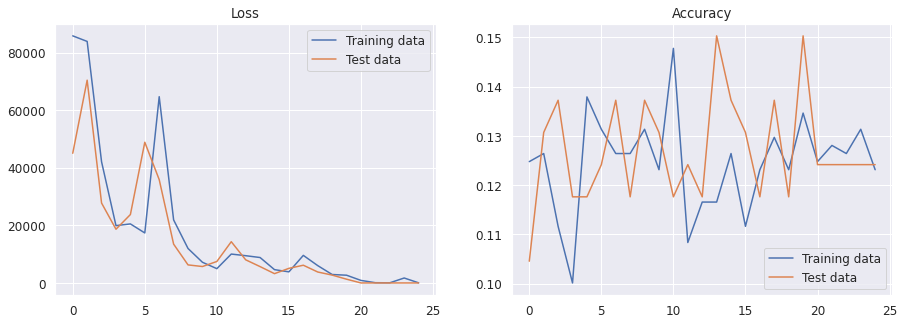

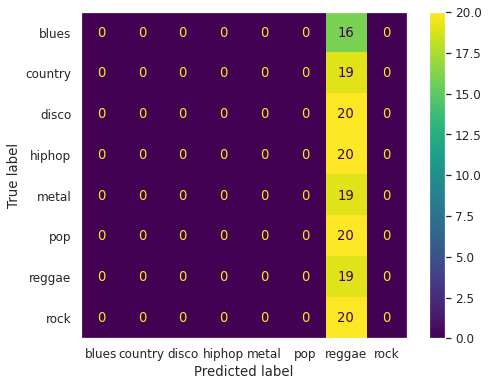

Accuracy  = 0.12418300653594772
F1 score  = 0.027435780513755892
Precision = 0.015421419112307233
Recall    = 0.12418300653594772


/home/lisa/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="lower right")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data:  {:.2%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data:      {:.2%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f} sec'.format(training_time_rnn))

pred_prob = model.predict([X_tf_test_seq, X_test_num])
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)